In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import datetime
from datetime import timedelta, datetime
from sklearn.cluster import MeanShift, KMeans
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
import math
import requests
import io
import warnings
   

from matplotlib import pyplot as plt
%matplotlib inline
warnings.simplefilter("ignore")

In [2]:
url = 'https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru'

In [3]:
req = requests.get(url)
s = req.content
encoding = req.encoding

In [228]:
df = pd.read_csv(io.StringIO(s.decode(encoding)), sep=';', header=1)
df.head()

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,RTL3,RTH3,DISCOUNT1,LIMIT1,DISCOUNT2,LIMIT2,DISCOUNT3,DISCOUNTL0,DISCOUNTH0,FULLCOVERED
0,AMUNIBB2AER2,UBANK11/22,UNIBANK OJSC Series 1,Корпоративные еврооблигации,AMUNIBB2AER2,NaN,3.0,"100,0",USD,10000.0,...,"0,0","12032,84","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
1,AMUNIBB2DER6,UBANK02/24,UNIBANK OJSC Series 1 21,Корпоративные еврооблигации,AMUNIBB2DER6,NaN,3.0,"100,0",USD,33478.0,...,"0,0","12203,74","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
2,AT0000A2UF10,Raiff CAG,Raiffeisen Centrobank AG,Корпоративные еврооблигации,AT0000A2UF10,NaN,3.0,"1000,0",USD,50000.0,...,"0,0","100143,68","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
3,CH0248531110,VTB-24 CHF,VTB CAPITAL S.A. 24 CHF,Корпоративные еврооблигации,CH0248531110,NaN,NaN,"5000,0",CHF,70000.0,...,"0,0","661375,58","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
4,CH0379268748,RZD-23 CHF,RZD Capital PLC 23 CHF,Корпоративные еврооблигации,CH0379268748,NaN,NaN,"5000,0",CHF,90000.0,...,"0,0","404209,06","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0


In [229]:
# Оставим только рублевые облигации с заполненной ставкой купона и датой начала торгов
df = df[(df.FACEUNIT == 'RUB') & (df.COUPONPERCENT.notnull()) & (df.ISSUEDATE.notnull())].copy()
df.shape

(2066, 54)

In [230]:
# Преобразуем некоторые признаки в формат datetime
df['MATDATE']= pd.to_datetime(df['MATDATE'], format='%d.%m.%Y')
df['COUPONDATE']= pd.to_datetime(df['COUPONDATE'], format='%d.%m.%Y')
df['ISSUEDATE']= pd.to_datetime(df['ISSUEDATE'], format='%d.%m.%Y')
df['STARTDATEMOEX']= pd.to_datetime(df['STARTDATEMOEX'])
df['OFFERDATE']= pd.to_datetime(df['OFFERDATE'])

In [231]:
# Преобразуем числовые признаки в float
df['COUPONPERCENT'] = df['COUPONPERCENT'].str.replace(',', '.').astype(float)
df['FACEVALUE'] = df['FACEVALUE'].str.replace(',', '.').astype(float)
df['INITIALFACEVALUE'] = df['INITIALFACEVALUE'].str.replace(',', '.').astype(float)
df['COUPONVALUE'] = df['COUPONVALUE'].str.replace(',', '.').astype(float)
df['YIELDATWAP'] = df['YIELDATWAP'].str.replace(',', '.').astype(float)
df['PRICE'] = df['PRICE'].str.replace(',', '.').astype(float)
df['PRICE_RUB'] = df['PRICE_RUB'].str.replace(',', '.').astype(float)
df['RTL1'] = df['RTL1'].str.replace(',', '.').astype(float)
df['RTH1'] = df['RTH1'].str.replace(',', '.').astype(float)
df['RTL2'] = df['RTL2'].str.replace(',', '.').astype(float)
df['RTH2'] = df['RTH2'].str.replace(',', '.').astype(float)
df['RTL3'] = df['RTL3'].str.replace(',', '.').astype(float)
df['RTH3'] = df['RTH3'].str.replace(',', '.').astype(float)

In [232]:
# Установим дату погашения, равной дате оферты, если она указана. Если в итоге не определилась, установим в далеком будущем
df['MATDATE'] = df[['MATDATE','OFFERDATE']].apply(lambda x: x.MATDATE \
                            if (x.OFFERDATE is pd.NaT) | (x.OFFERDATE < datetime.now()) \
                            else x.OFFERDATE, axis=1)
df['MATDATE'] = df['MATDATE'].fillna(datetime(year=2100, month=12, day=31)) 
df['MATDATE']= pd.to_datetime(df['MATDATE'])

# Установим уровень листинга 3, где не указан
df['LISTLEVEL'] = df['LISTLEVEL'].fillna(3)  

# Посчитаем дюрацию как срок до погашения, где не указано
df['DURATION'] = df['DURATION'].fillna((df['MATDATE'] - datetime.now()).dt.days)  

# Оставим записи, где дюрация больше 0 и заполнено количество дней до погашения
df = df[(df.DURATION > 0) & (df.DAYSTOREDEMPTION.notnull())].copy()

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2032 entries, 12 to 2656
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   SECID                   2032 non-null   object        
 1   SHORTNAME               2032 non-null   object        
 2   NAME                    2032 non-null   object        
 3   TYPENAME                2032 non-null   object        
 4   ISIN                    2032 non-null   object        
 5   REGNUMBER               1967 non-null   object        
 6   LISTLEVEL               2032 non-null   float64       
 7   FACEVALUE               2032 non-null   float64       
 8   FACEUNIT                2032 non-null   object        
 9   ISSUESIZE               2032 non-null   float64       
 10  IS_COLLATERAL           2032 non-null   int64         
 11  IS_EXTERNAL             2032 non-null   int64         
 12  PRIMARY_BOARDID         2032 non-null   object 

## Задание 1.

### 1.	Оценить рынок рублевых облигаций по распределению купонной доходности

In [234]:
# Текущая дата

current_date = datetime.now()

In [235]:
df.shape

(2032, 54)

In [236]:
# Найдём выборочное среднее, дисперию, стандартное отклонение, медиану и моду.

mu = np.mean(df.COUPONPERCENT)
var = np.var(df.COUPONPERCENT)
std = np.std(df.COUPONPERCENT)
median = np.median(df.COUPONPERCENT)
moda = stats.mode(df.COUPONPERCENT)[0][0]
print('Выборочное среднее = %.4f' % mu)
print('Дисперсия = %.4f' % var)
print('Стандартное отклонение = %.4f' % std)
print('Медиана = %.4f' % median)
print('Мода = %.4f' % moda)

Выборочное среднее = 6.8164
Дисперсия = 25.5248
Стандартное отклонение = 5.0522
Медиана = 7.5500
Мода = 0.0100


Видим очень большую дисперсию, также мода сильно отличается от среднего. Можем предположить, что в выборке присутствуют несколько процессов.

<AxesSubplot:xlabel='COUPONPERCENT', ylabel='Density'>

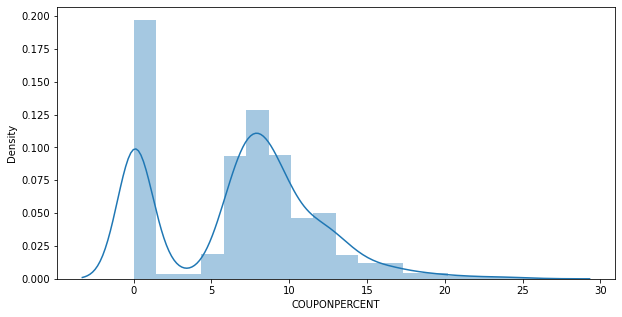

In [237]:
# Построим гистограмму и ядерную оценку плотности

fig = plt.figure(figsize=(10, 5))

sns.distplot(df.COUPONPERCENT)

Видим два локальных максимума и длинный правый хвост, т.е. у распределения много выбросов. Значение ставки купона 0,01 сильно отличается от распределения остальных значений ставки. Посмотрим подробнее на наиболее часть встречающиеся значения ставки.

In [238]:
df.COUPONPERCENT.value_counts().head(10)

0.01     487
13.00     37
12.00     36
9.50      31
11.00     28
12.50     27
8.00      25
9.00      25
7.50      24
10.00     24
Name: COUPONPERCENT, dtype: int64

Видим, что действительно купонов со ставкой 0,01 на порядок больше, чем купонов с остальными ставками. Поищем, чем быть обусловлено.

[]

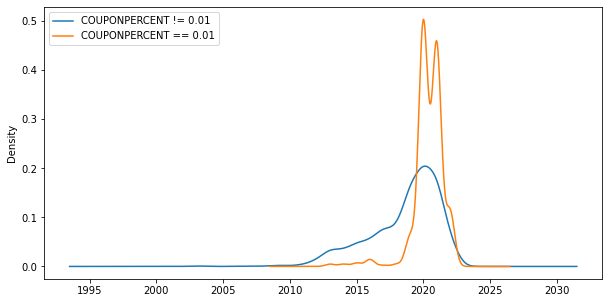

In [239]:
# Посмотрим, может зависит от даты выпуска
fig = plt.figure(figsize=(10, 5))

df[df.COUPONPERCENT != 0.01]['ISSUEDATE'].apply(lambda x: x.year).plot(kind='density', label='COUPONPERCENT != 0.01')
df[df.COUPONPERCENT == 0.01]['ISSUEDATE'].apply(lambda x: x.year).plot(kind='density', label='COUPONPERCENT == 0.01')

plt.legend()
plt.plot()

Явной зависимости от года выпуска не видим. Посмотрим зависимость от категориальных признаков.

In [240]:
# Введем флаг по COUPONPERCENT = 0.01
df['flag_001'] = df.COUPONPERCENT.apply(lambda x: 1 if x==0.01 else 0)

# Где частота купона и размер купона не указаны, поставим 0
df['COUPONFREQUENCY'] = df['COUPONFREQUENCY'].fillna(0)  
df['COUPONVALUE'] = df['COUPONVALUE'].fillna(0)

In [241]:
cat_col = ['TYPENAME','LISTLEVEL','IS_COLLATERAL','PRIMARY_BOARDID','HIGH_RISK','COUPONFREQUENCY']

df[cat_col].isnull().sum()

TYPENAME           0
LISTLEVEL          0
IS_COLLATERAL      0
PRIMARY_BOARDID    0
HIGH_RISK          0
COUPONFREQUENCY    0
dtype: int64

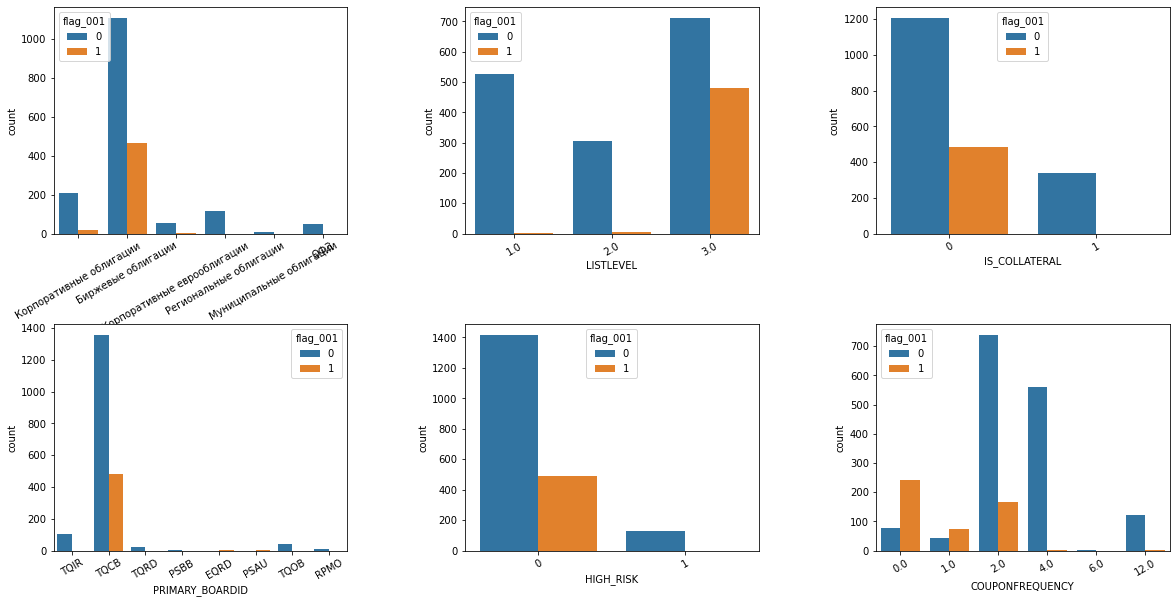

In [242]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, col in enumerate(cat_col):
    plt.subplot(2,3,i+1)
    sns.countplot(x=df[col], hue=df['flag_001'])
    plt.xticks(rotation=30)

Видим, что облигации со ставкой купона 0.01% низкорисковые (HIGH_RISK=0), только в 3-ем уровне листинга и без обеспечения (LISTLEVEL=3, IS_COLLATERAL=0).

Посмотрим зависимость от числовых признаков.

In [243]:
num_col = ['FACEVALUE','ISSUESIZE','DURATION','COUPONVALUE','COUPONLENGTH','INITIALFACEVALUE','DAYSTOREDEMPTION',\
           'PRICE','PRICE_RUB']

df[num_col].isnull().sum()

FACEVALUE           0
ISSUESIZE           0
DURATION            0
COUPONVALUE         0
COUPONLENGTH        1
INITIALFACEVALUE    0
DAYSTOREDEMPTION    0
PRICE               8
PRICE_RUB           8
dtype: int64

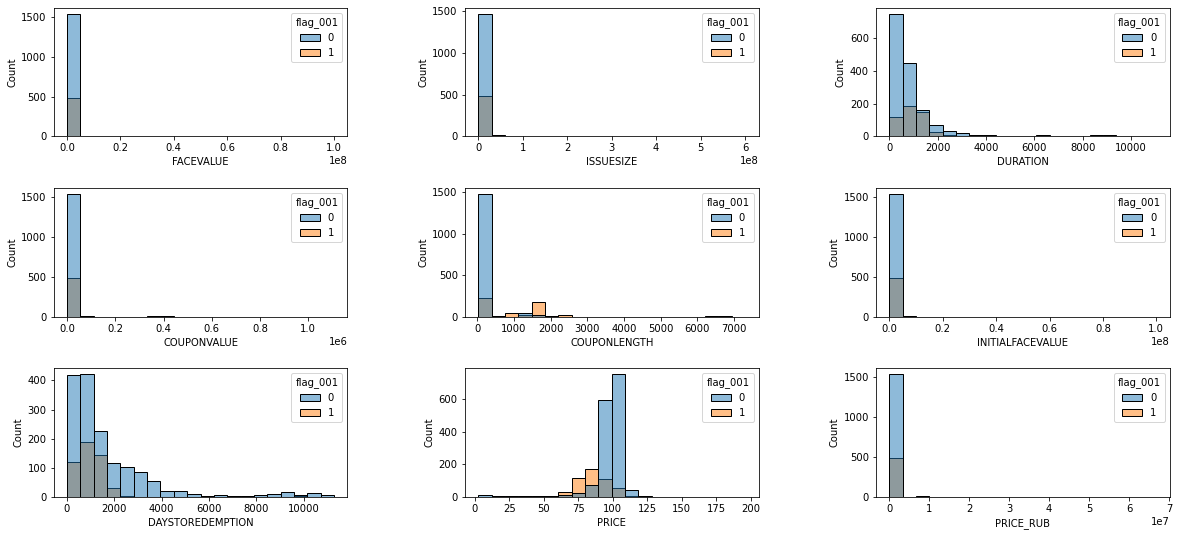

In [244]:
# Построим гистограммы числовых признаков с группировкой по новому флагу
fig = plt.figure(figsize=(20, 9))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, col in enumerate(num_col):
    plt.subplot(3, 3, i+1)
    sns.histplot(data = df, x=col, hue='flag_001', bins=20)

Видим, что у всех распределений длинные хвосты. Попробуем прологарифмировать.

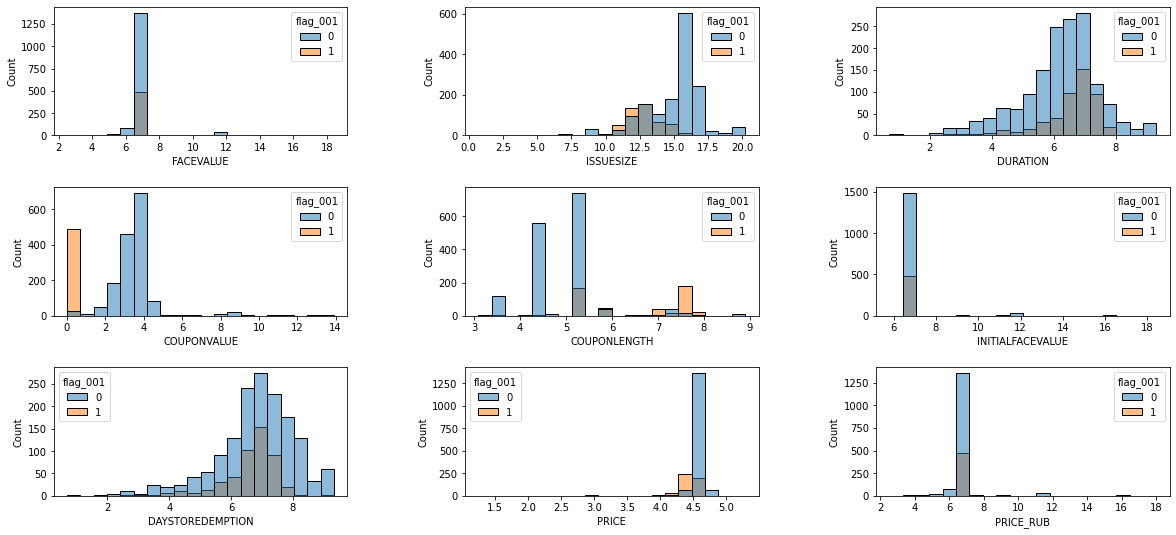

In [245]:
df_log = df[num_col + ['flag_001']].copy()
df_log[num_col] = df_log[num_col].apply(lambda x: np.log(x+1))

# Построим гистограммы числовых признаков с группировкой по новому флагу
fig = plt.figure(figsize=(20, 9))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, col in enumerate(num_col):
    plt.subplot(3, 3, i+1)
    sns.histplot(data = df_log, x=col, hue='flag_001', bins=20)

Видим, что у облигаций со ставкой купона 0.01% всегда маленькая сумма купона (COUPONVALUE), также длительный купонный период (COUPONLENGTH) наблюдается только у этих облигаций.

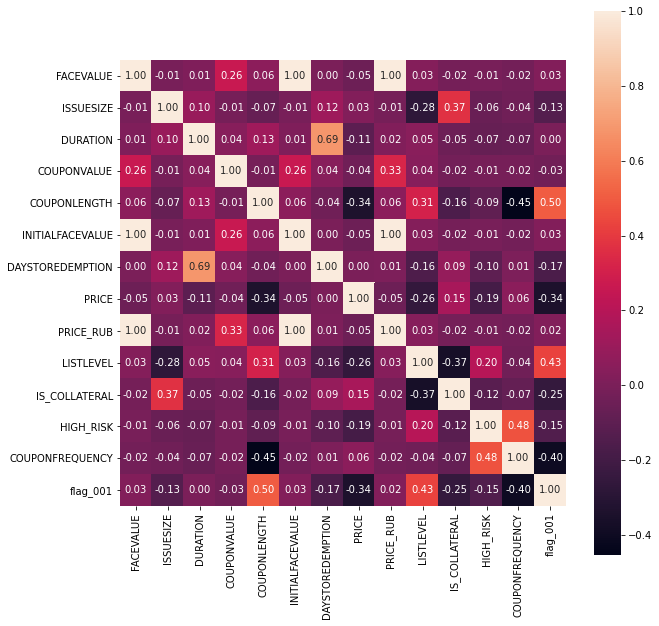

In [246]:
# Посмотрим на матрицу корреляций
plt.subplots(figsize=(10,10))
sns.heatmap(df[num_col + cat_col + ['flag_001']].corr(), fmt=".2f", annot=True, square=True)
plt.show()

Видим, что у введеного признака flag_001 достаточно сильная положительная корреляция с длиной купонного периода (COUPONLENGTH) и уровнем листинга (LISTLEVEL) и отрицательная корреляция с ценой в %% (PRICE) и частотой выплаты купона (COUPONFREQUENCY).

Исходя из анализа выше, будем считать, что облигации со ставкой купона 0.01% - это отдельная группа облигаций, выделим их в отдельный кластер и далее будем рассматривать датасет без них.

In [247]:
bonds_001 = df[df.flag_001 == 1].copy()
bonds = df[df.flag_001 != 1].copy()

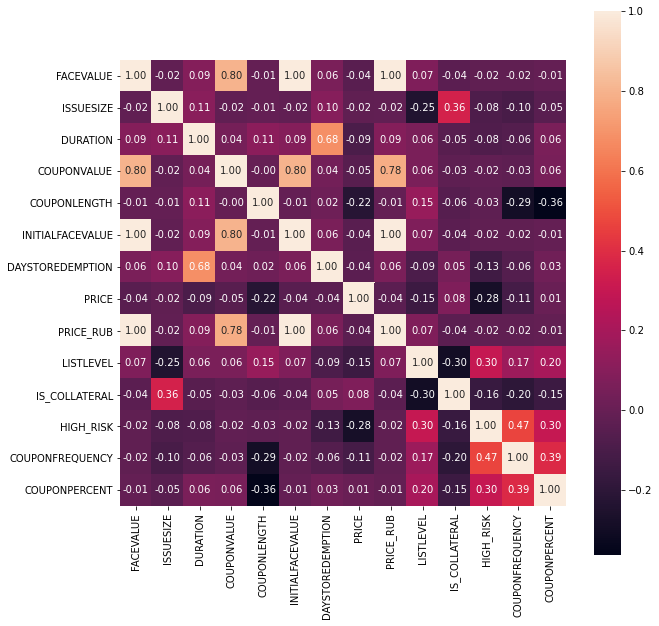

In [248]:
# Посмотрим на матрицу корреляций облигаций с flag_001 != 1
plt.subplots(figsize=(10,10))
sns.heatmap(bonds[num_col + cat_col + ['COUPONPERCENT']].corr(), fmt=".2f", annot=True, square=True)
plt.show()

Видим положительную зависимость купонного дохода (COUPONPERCENT) от частоты выплаты купона (COUPONFREQUENCY), уровня риска (HIGH_RISK) и уровня листинга (LISTLEVEL) и отрицательную зависимость от длины купонного периода (COUPONLENGTH) и наличия обеспечения (IS_COLLATERAL)

In [249]:
# Посмотрим на характеристики нового датасета.

mu = np.mean(bonds.COUPONPERCENT)
var = np.var(bonds.COUPONPERCENT)
std = np.std(bonds.COUPONPERCENT)
median = np.median(bonds.COUPONPERCENT)
moda = stats.mode(bonds.COUPONPERCENT)[0][0]
print('Выборочное среднее = %.4f' % mu)
print('Дисперсия = %.4f' % var)
print('Стандартное отклонение = %.4f' % std)
print('Медиана = %.4f' % median)
print('Мода = %.4f' % moda)

Выборочное среднее = 8.9619
Дисперсия = 14.3648
Стандартное отклонение = 3.7901
Медиана = 8.5000
Мода = 13.0000


Дисперсия осталась большой, на графике видно, что два локальных максимума и длинный правый хвост остались.

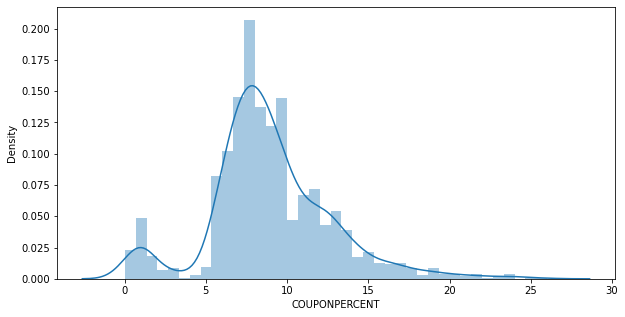

In [250]:
fig = plt.figure(figsize=(10, 5))

sns.distplot(bonds.COUPONPERCENT);

<AxesSubplot:>

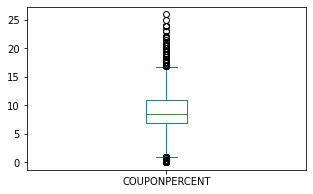

In [251]:
# Посмотрим на распределение на boxplot

bonds.COUPONPERCENT.plot(kind='box')

Видим очень много выбросов. Вожможно такие облигации также нужно выделить в отдельную группу.

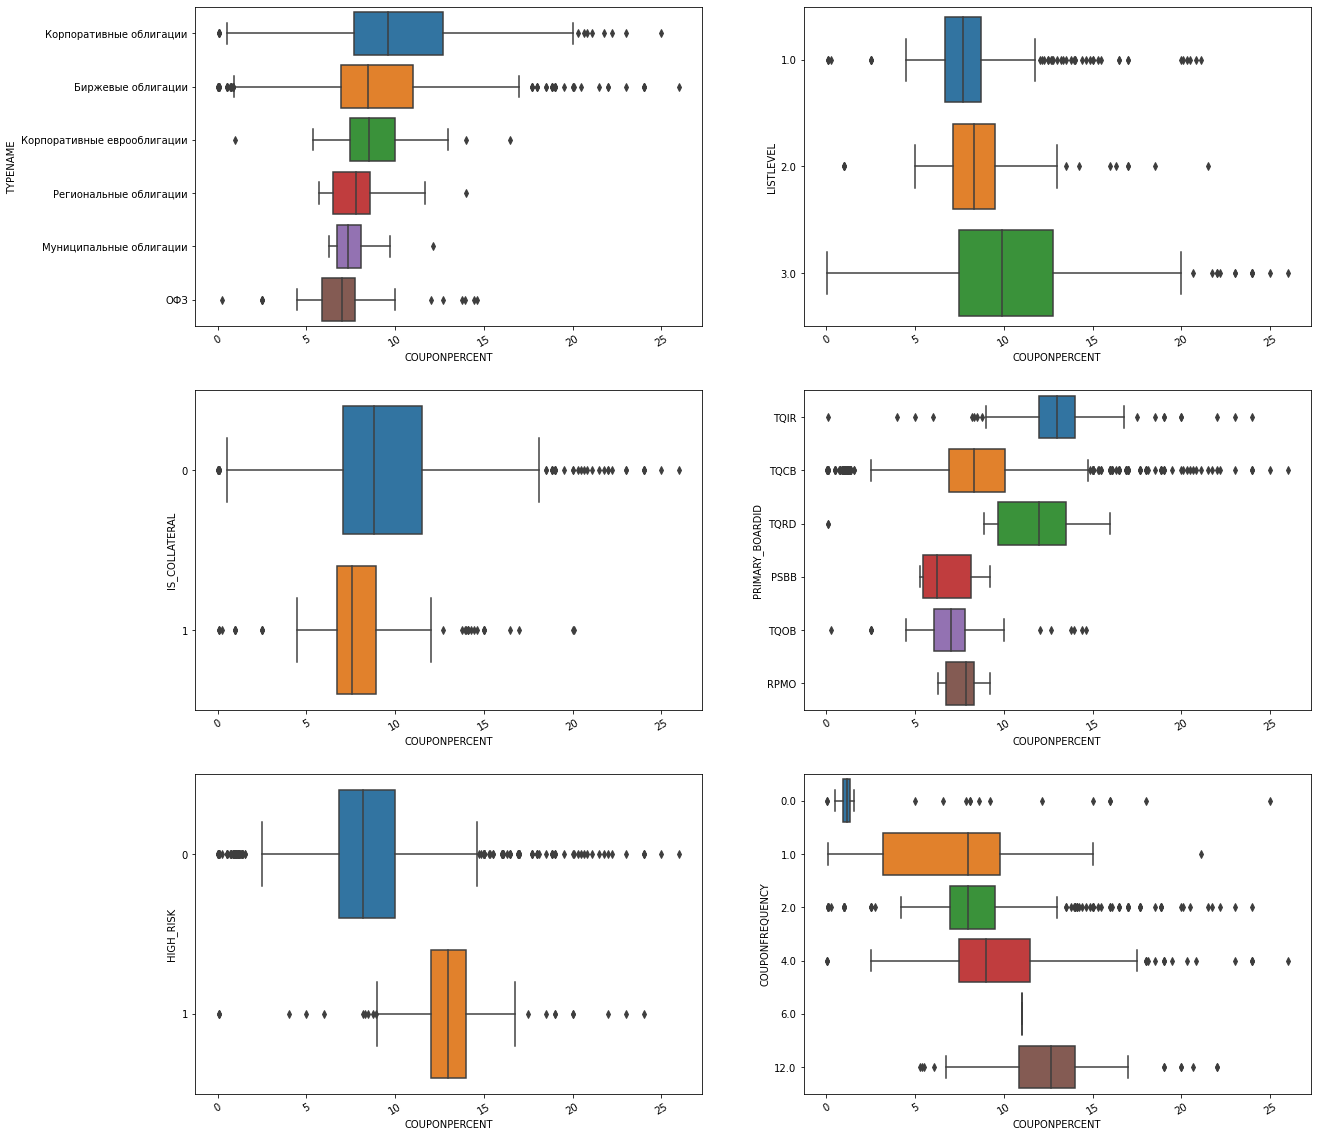

In [252]:
# Посмотрим на распределение на boxplot в зависимости от категориальных переменных

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i, col in enumerate(cat_col):
    plt.subplot(3,2,i+1)
    sns.boxplot(y=col, x='COUPONPERCENT', data=bonds, orient="h")
    plt.xticks(rotation=30)

Выбросов по-прежнему очень много, но наблюдаются они не везде. Некоторые группы имеют очень плотное распределение, почти везде медиана отличается от среднего. Явные отличия медианы и разброса ставки мы видим у признаков:
1. Наличие обеспечения (IS_COLLATERAL)
2. Уровень риска (HIGH_RISK)
3. PRIMARY_BOARDID
4. Для уровня листинга (LISTLEVEL) есть различие между (1+2) и 3. В дальшейшем ввдем новый признак is_LISTLEVEL3 для обучения модели
5. Частота выплаты купона (COUPONFREQUENCY)

### 2. Предложить разделение на кластеры по купонной доходности. Предложить графическое представление полученных групп/кластеров. (график)

In [253]:
# Введем признак is_LISTLEVEL3
bonds['is_LISTLEVEL3'] = bonds['LISTLEVEL'].apply(lambda x: 1 if x==3 or np.isnan(x) else 0)

# Введем признак "Год выпуска"
bonds['ISSUE_year'] = bonds['ISSUEDATE'].apply(lambda x: x.year)

In [254]:
bonds_copy = bonds.copy()

In [255]:
# Попробуем разделить облигации на кластеры с помощью метода k-Means

col_for_clasters = ['TYPENAME','is_LISTLEVEL3','IS_COLLATERAL','PRIMARY_BOARDID','HIGH_RISK','COUPONFREQUENCY','ISSUE_year',\
        'FACEVALUE','ISSUESIZE','DURATION','COUPONVALUE','COUPONLENGTH','INITIALFACEVALUE','DAYSTOREDEMPTION','PRICE',\
        'PRICE_RUB','COUPONPERCENT']

bonds = bonds[col_for_clasters]

# Удалим оставшиеся пропущенные значения
bonds = bonds.dropna()
bonds = bonds.reset_index()
bonds.head()

,index,TYPENAME,is_LISTLEVEL3,IS_COLLATERAL,PRIMARY_BOARDID,HIGH_RISK,COUPONFREQUENCY,ISSUE_year,FACEVALUE,ISSUESIZE,DURATION,COUPONVALUE,COUPONLENGTH,INITIALFACEVALUE,DAYSTOREDEMPTION,PRICE,PRICE_RUB,COUPONPERCENT
0,12,Корпоративные облигации,1,0,TQIR,1,0.0,2009,1000.0,40800.0,2425.0,1000.55,7304.0,1000.0,2426.0,100.00,1668.22,5.00
1,13,Корпоративные облигации,0,1,TQCB,0,2.0,2009,1000.0,10000000.0,622.0,39.14,182.0,1000.0,663.0,99.67,1010.68,7.85
2,14,Корпоративные облигации,0,1,TQCB,0,2.0,2009,1000.0,7000000.0,229.0,83.18,184.0,1000.0,243.0,102.48,1079.95,16.50
3,15,Корпоративные облигации,0,1,TQCB,0,2.0,2009,1000.0,7000000.0,1222.0,100.82,184.0,1000.0,2193.0,109.03,1190.57,20.00
4,16,Корпоративные облигации,0,1,TQCB,0,2.0,2010,1000.0,15000000.0,788.0,39.14,182.0,1000.0,855.0,99.80,1009.83,7.85


In [256]:
bonds.shape

(1539, 18)

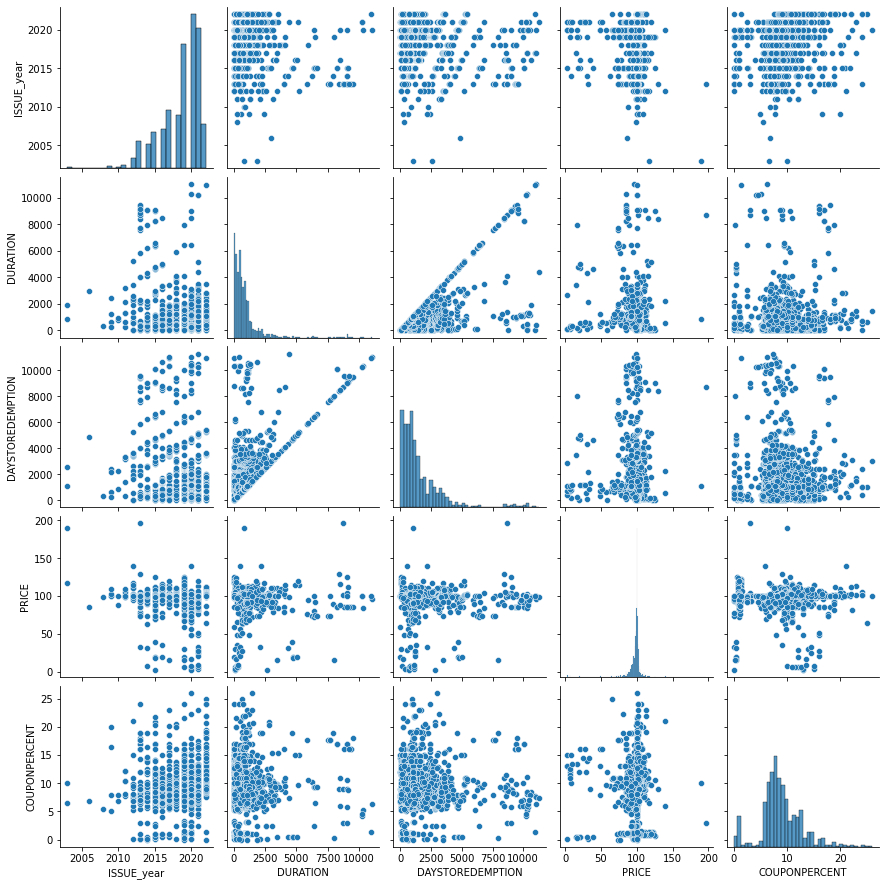

In [257]:
# Посмотрим на получившиеся данные визуально

sns.pairplot(bonds[['ISSUE_year','DURATION','DAYSTOREDEMPTION','PRICE','COUPONPERCENT']])

На графиках визуально видно разделение данных на области по некоторым признакам

In [258]:
# Закодируем некоторые категориальные переменные

bonds = pd.get_dummies(bonds, columns=['TYPENAME','PRIMARY_BOARDID'], prefix=['TN', 'PB'])
bonds.head(3)

,index,is_LISTLEVEL3,IS_COLLATERAL,HIGH_RISK,COUPONFREQUENCY,ISSUE_year,FACEVALUE,ISSUESIZE,DURATION,COUPONVALUE,...,TN_Корпоративные еврооблигации,TN_Корпоративные облигации,TN_Муниципальные облигации,TN_ОФЗ,TN_Региональные облигации,PB_RPMO,PB_TQCB,PB_TQIR,PB_TQOB,PB_TQRD
0,12,1,0,1,0.0,2009,1000.0,40800.0,2425.0,1000.55,...,0,1,0,0,0,0,0,1,0,0
1,13,0,1,0,2.0,2009,1000.0,10000000.0,622.0,39.14,...,0,1,0,0,0,0,1,0,0,0
2,14,0,1,0,2.0,2009,1000.0,7000000.0,229.0,83.18,...,0,1,0,0,0,0,1,0,0,0


По методу локтя найдем оптимальное количество кластеров.

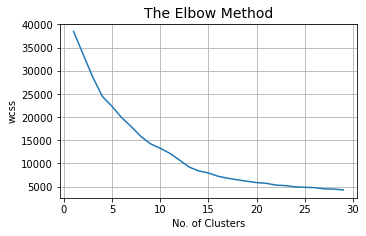

In [259]:
cols = ['COUPONLENGTH','PRICE','HIGH_RISK','COUPONFREQUENCY','is_LISTLEVEL3', 'IS_COLLATERAL','COUPONPERCENT',
        'ISSUE_year','FACEVALUE','ISSUESIZE','DURATION','COUPONVALUE','INITIALFACEVALUE','DAYSTOREDEMPTION',
        'TN_Биржевые облигации','TN_Корпоративные еврооблигации', 'TN_Корпоративные облигации',
        'TN_Муниципальные облигации', 'TN_ОФЗ', 'TN_Региональные облигации',
        'PB_RPMO', 'PB_TQCB', 'PB_TQIR', 'PB_TQOB', 'PB_TQRD']

#cols = bonds.columns[1:]

x = bonds.loc[:,cols]
# Нормализуем данные
X = StandardScaler().fit_transform(x)

wcss = []
for i in range(1, 30):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0,
                algorithm = 'elkan',
                tol = 0.001)
    
    km.fit(X)
    labels = km.labels_
    wcss.append(km.inertia_)
    
plt.rcParams['figure.figsize'] = (5, 3)
plt.plot(range(1, 30), wcss)
plt.grid()
plt.tight_layout()
plt.title('The Elbow Method', fontsize = 14)
plt.xlabel('No. of Clusters', fontsize = 10)
plt.ylabel('wcss', fontsize = 10)
plt.show()

С большим количеством признаков оптимальное количество кластеров велико. Уменьшим количество признаков для уменьшения оптимального количества кластеров.

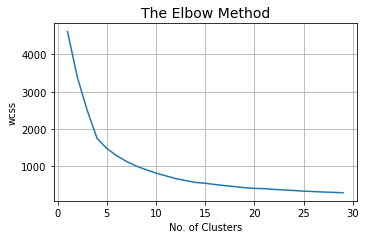

In [260]:
cols = ['PRICE','COUPONPERCENT','DURATION']

# x = np.array(bonds.COUPONPERCENT).reshape(-1, 1)
x = bonds.loc[:,cols]

# Нормализуем данные
X = StandardScaler().fit_transform(x)

wcss = []
for i in range(1, 30):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0,
                algorithm = 'elkan',
                tol = 0.001)
    
    km.fit(X)
    labels = km.labels_
    wcss.append(km.inertia_)
    
plt.rcParams['figure.figsize'] = (5, 3)
plt.plot(range(1, 30), wcss)
plt.grid()
plt.tight_layout()
plt.title('The Elbow Method', fontsize = 14)
plt.xlabel('No. of Clusters', fontsize = 10)
plt.ylabel('wcss', fontsize = 10)
plt.show()

Обучим модель, используя только признаки PRICE, COUPONPERCENT, DURATION с гиперпараметром n_clusters = 4

In [261]:
# x = bonds.loc[:,cols]
# x = np.array(bonds.COUPONPERCENT).reshape(-1, 1)
# Нормализуем данные
# X = StandardScaler().fit_transform(x)

km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0).fit(X)

#bonds.insert(0, 'Cluster Labels', km.labels_)
bonds['Cluster_Labels'] = km.labels_
bonds.head()

,index,is_LISTLEVEL3,IS_COLLATERAL,HIGH_RISK,COUPONFREQUENCY,ISSUE_year,FACEVALUE,ISSUESIZE,DURATION,COUPONVALUE,...,TN_Корпоративные облигации,TN_Муниципальные облигации,TN_ОФЗ,TN_Региональные облигации,PB_RPMO,PB_TQCB,PB_TQIR,PB_TQOB,PB_TQRD,Cluster_Labels
0,12,1,0,1,0.0,2009,1000.0,40800.0,2425.0,1000.55,...,1,0,0,0,0,0,1,0,0,0
1,13,0,1,0,2.0,2009,1000.0,10000000.0,622.0,39.14,...,1,0,0,0,0,1,0,0,0,0
2,14,0,1,0,2.0,2009,1000.0,7000000.0,229.0,83.18,...,1,0,0,0,0,1,0,0,0,1
3,15,0,1,0,2.0,2009,1000.0,7000000.0,1222.0,100.82,...,1,0,0,0,0,1,0,0,0,1
4,16,0,1,0,2.0,2010,1000.0,15000000.0,788.0,39.14,...,1,0,0,0,0,1,0,0,0,0


In [262]:
# Получились кластеры
bonds['Cluster_Labels'].value_counts()

0    1061
1     403
2      41
3      34
Name: Cluster_Labels, dtype: int64

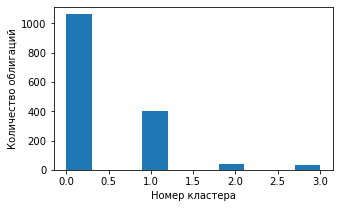

In [263]:
bonds['Cluster_Labels'].plot(kind='hist')

plt.ylabel('Количество облигаций')
plt.xlabel('Номер кластера') 
plt.show()

In [264]:
# Посмотрим статистические характеристики в разрезе кластеров

claster_groups = bonds.groupby('Cluster_Labels')
claster_groups.describe()['COUPONPERCENT']

,count,mean,std,min,25%,50%,75%,max
Cluster_Labels,,,,,,,,
0,1061.0,7.225433,2.268766,0.016,6.5500,7.65,8.700,11.00
1,403.0,13.276660,2.924519,9.750,11.2500,12.50,14.000,26.00
2,41.0,11.271220,5.392743,1.400,6.5000,10.15,16.900,18.83
3,34.0,9.598824,5.926427,0.100,2.3825,12.00,13.875,16.00


Нулевой кластер самый многочисленный, в него попали облигации с низкими ставками купона, и среднее и медиана ниже, чем в других кластерах. Сдедующий по количеству облигаций - первый кластер, в него попали облигации с высокими ставками купона и среднее и медиана выше, чем в других кластерах. Дисперсия у этих кластеров не велика, распределение достаточно плотное. Два других кластера малочислены и имеют большую дисперсию.

Построим графики распределения COUPONPERCENT по кластерам.

[]

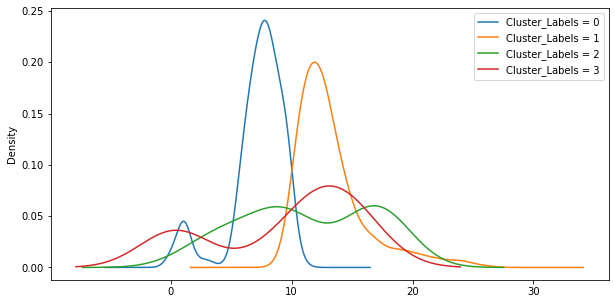

In [265]:
fig = plt.figure(figsize=(10, 5))

bonds[bonds.Cluster_Labels == 0]['COUPONPERCENT'].plot(kind='density', label='Cluster_Labels = 0')
bonds[bonds.Cluster_Labels == 1]['COUPONPERCENT'].plot(kind='density', label='Cluster_Labels = 1')
bonds[bonds.Cluster_Labels == 2]['COUPONPERCENT'].plot(kind='density', label='Cluster_Labels = 2')
bonds[bonds.Cluster_Labels == 3]['COUPONPERCENT'].plot(kind='density', label='Cluster_Labels = 3')

plt.legend()
plt.plot()

Посмотрим это на boxplot.

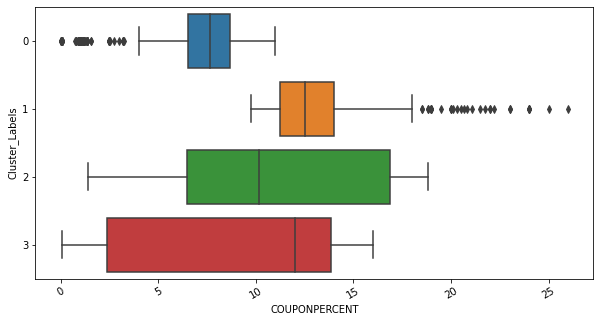

In [267]:
fig = plt.figure(figsize=(10, 5))
sns.boxplot(y='Cluster_Labels', x='COUPONPERCENT', data=bonds, orient="h")

plt.xticks(rotation=30);

Видим, подтверждение выводов выше. 0-ой и 1-ый кластеры имеют плотное распределение, 2-ой и 3-ий "размазаны". Медиана 2-ого больше смещена влево, медиана 3-его вправо.

Посмотрим на графиках зависимость COUPONPERCENT от дюрации, цены в %%, количества дней до погашения и частоты выплаты купонов.

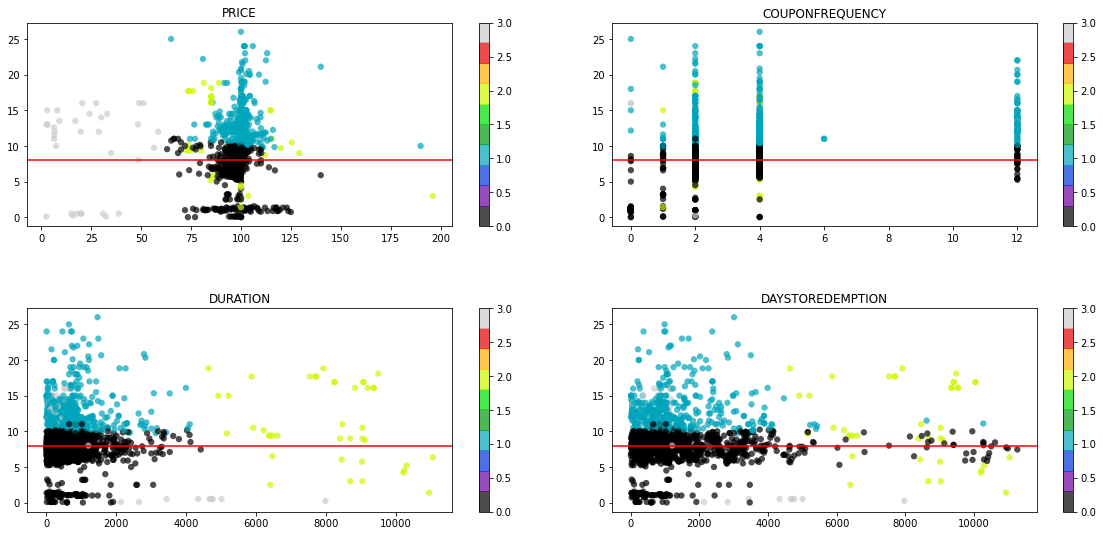

In [268]:
fig = plt.figure(figsize=(20, 9))
fig.subplots_adjust(hspace=0.4, wspace=0.1)

col_lst = ['PRICE','COUPONFREQUENCY','DURATION','DAYSTOREDEMPTION']
    
for i, col in enumerate(col_lst):
    plt.subplot(2, 2, i+1)
    plt.scatter(bonds[col], bonds.COUPONPERCENT, c=bonds['Cluster_Labels'],
                edgecolor='none', alpha=0.7, s=40,
                cmap=plt.cm.get_cmap('nipy_spectral', 10))
    plt.axhline(y = 8, color = 'r', linestyle = '-')
    plt.colorbar()
    plt.title(col)

На графиках видим четкое разделение на кластеры. Облигации из 2-го кластера имеют высокую дюрацию. Облигации из 3-го кластера - низкую цену. Облигации 0-го и 1-го кластеров четко различаются по ставке купона.

## Задание 2.

### По низкорисковым рублевым облигациям с датой промежуточной выплаты по купонам не более 20% купонного периода назад до текущей даты и облигациям выпущенным в аналогичный период, рассчитать доходность последующих купонов по отобранным облигациям с учетом разницы номинала и цены продажи, а также с учетом налоговых отчислений на период год с текущей дата. (график и/или таблица). 

Сформируем новый датасет согласно условиям:

    1. Низкорисковые рублевые облигации 
    2. Облигации с датой промежуточной выплаты по купонам не более 20% купонного периода назад до текущей даты и облигации выпущенным в аналогичный период

In [269]:
df2 = df[(df.HIGH_RISK == 0) & (df.COUPONDAYSPASSED/df.COUPONLENGTH <= 0.2) & (df.COUPONDAYSPASSED>=0)].copy()

# Удалим записи, где не указана цена
df2 = df2[df2.PRICE.notnull()]

df2.shape

(330, 55)

#### Доходность будем считать по формуле<p>

$$ Profit =  \frac {( (Цена\_номинальная  – Цена\_покупки ) * (1 ЕСЛИ ≤0│0.87 ЕСЛИ>0)  –  НКД + 0.87 * Купонный\_доход\_руб * X\_лет) * 100% )}{( (Цена\_покупки+ НКД) * (1+Комиссия\_брокера\_в\_процентах/100 + Комиссия\_биржи/100) )} $$



In [270]:
# Введем признак "Количество дней до погашения", который будет равен:
# 1. 365 для облигаций со сроком погашения после "текущая дата + 365"
# 2. Количеству дней до MATDATE со сроком погашения до "текущая дата + 365" (ранее MATDATE обновили с учетом OFFERDATE)

df2['DAYS_TO_MATDATE'] = df2['MATDATE'].apply(lambda x: (x - current_date).days if (x - current_date).days <= 365 else 365)

# Посчитаем дельту цены облигации
df2['DELTA_PRICE'] = df2[['FACEVALUE','PRICE']].apply(lambda x: (x.FACEVALUE - x.FACEVALUE*x.PRICE/100) \
                                                         if (x.FACEVALUE - x.FACEVALUE*x.PRICE/100) <= 0 \
                                                         else 0.87*(x.FACEVALUE - x.FACEVALUE*x.PRICE/100), axis=1)

# Посчитаем НКД
df2['NKD'] = df2['COUPONVALUE']/df2['COUPONLENGTH'] * (df2['COUPONDAYSPASSED']+1)

# Посчитаем купонный доход на период год с текущей даты, учитывая новый признак "Количество дней до погашения"
df2['YEAR_COUPONVALUE'] = (df2['FACEVALUE'] * df2['COUPONPERCENT'] / 100) * (df2['DAYS_TO_MATDATE'] / 365)

# Комиссия брокера
broker_comm = 0.06 / 100

# Комиссия Биржи
exchange_comm = 0.0125 / 100

In [271]:
# Посчитаем доходность последующих купонов на период год с текущей даты

df2['PROFIT'] = (df2.DELTA_PRICE - df2.NKD + 0.87*df2.YEAR_COUPONVALUE) * 100 /  \
                ( (df2.PRICE_RUB + df2.NKD) * (1 + broker_comm + exchange_comm) )

df2.head()

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,DISCOUNT3,DISCOUNTL0,DISCOUNTH0,FULLCOVERED,flag_001,DAYS_TO_MATDATE,DELTA_PRICE,NKD,YEAR_COUPONVALUE,PROFIT
24,RU000A0JS4J1,ЗСД 03,Запад.скор.диаметр АО об.03,Корпоративные облигации,RU000A0JS4J1,4-03-00350-D,1.0,1000.0,RUB,5000000.0,...,"35,0","10,00000","10,00000",0.0,0,365,-101.5000,7.279615,98.400,-2.075197
25,RU000A0JS4K9,ЗСД 04,Запад.скор.диаметр АО об.04,Корпоративные облигации,RU000A0JS4K9,4-04-00350-D,1.0,1000.0,RUB,5000000.0,...,"37,0","31,00000","13,00000",0.0,0,365,-167.4000,7.279615,98.400,-7.532188
26,RU000A0JS4L7,ЗСД 05,Запад.скор.диаметр АО об.05,Корпоративные облигации,RU000A0JS4L7,4-05-00350-D,1.0,1000.0,RUB,5000000.0,...,NaN,"10,00000","10,00000",1.0,0,365,-109.9000,7.279615,98.400,-2.806354
27,RU000A0JS4Z7,ВЭБ.РФ 21,ВЭБ.РФ об. сер. 21,Корпоративные облигации,RU000A0JS4Z7,4-26-00004-T,1.0,1000.0,RUB,15000000.0,...,"16,0","10,00000","10,00000",0.0,0,365,-20.7000,4.817582,109.900,6.800202
35,RU000A0JT593,ВолгСпорт2,Волга-Спорт АО обл. 02,Корпоративные облигации,RU000A0JT593,4-02-20468-P,1.0,329.0,RUB,1900000.0,...,NaN,"10,00000","10,00000",1.0,0,365,-131.4355,2.852877,69.419,-15.847163


In [272]:
df2['PROFIT'].sort_values(ascending=False)

2284    462.364790
1941     68.264103
1775     57.966207
1735     56.766484
1791     53.974519
           ...    
2413    -15.557890
35      -15.847163
78      -16.581649
2308    -42.786213
1878    -47.312788
Name: PROFIT, Length: 330, dtype: float64

In [273]:
mu = np.mean(df2.PROFIT)
var = np.var(df2.PROFIT)
std = np.std(df2.PROFIT)
min = np.min(df2.PROFIT)
max = np.max(df2.PROFIT)
median = np.median(df2.PROFIT)
moda = stats.mode(df2.PROFIT)[0][0]
print('Выборочное среднее = %.4f' % mu)
print('Дисперсия = %.4f' % var)
print('Стандартное отклонение = %.4f' % std)
print('Минимум = %.4f' % min)
print('Максимум = %.4f' % max)
print('Медиана = %.4f' % median)
print('Мода = %.4f' % moda)

Выборочное среднее = 12.1736
Дисперсия = 772.1726
Стандартное отклонение = 27.7880
Минимум = -47.3128
Максимум = 462.3648
Медиана = 7.6781
Мода = 0.0085


In [274]:
# Выделим в отдельные группы облигации с отрицательной доходностью и доходностью больше 40%

df2['Cluster'] = 0

df2['Cluster'] = np.where(df2.PROFIT>40, 1, df2['Cluster'])
df2['Cluster'] = np.where(df2.PROFIT<0, 2, df2['Cluster'])

df3 = df2[df2['Cluster']==0].copy()
df3.head()

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,DISCOUNTL0,DISCOUNTH0,FULLCOVERED,flag_001,DAYS_TO_MATDATE,DELTA_PRICE,NKD,YEAR_COUPONVALUE,PROFIT,Cluster
27,RU000A0JS4Z7,ВЭБ.РФ 21,ВЭБ.РФ об. сер. 21,Корпоративные облигации,RU000A0JS4Z7,4-26-00004-T,1.0,1000.0,RUB,15000000.0,...,"10,00000","10,00000",0.0,0,365,-20.700,4.817582,109.9,6.800202,0
55,RU000A0JTS06,Роснефть07,ПАО НК Роснефть обл.07,Корпоративные облигации,RU000A0JTS06,4-07-00122-A,1.0,1000.0,RUB,15000000.0,...,"10,00000","10,00000",0.0,0,176,3.219,1.200000,35.2,3.266835,0
56,RU000A0JTS22,Роснефть08,ПАО НК Роснефть обл.08,Корпоративные облигации,RU000A0JTS22,4-08-00122-A,1.0,1000.0,RUB,15000000.0,...,"10,00000","10,00000",0.0,0,176,2.871,1.200000,35.2,3.230714,0
63,RU000A0JTYJ6,ФСК ЕЭС-23,"""ФСК ЕЭС""(ПАО)-обл. сер.23",Корпоративные облигации,RU000A0JTYJ6,4-23-65018-D,3.0,1000.0,RUB,10000000.0,...,"10,00000","10,00000",1.0,0,365,130.152,7.498681,161.0,30.352084,0
64,RU000A0JTYK4,ФСК ЕЭС-28,"""ФСК ЕЭС""(ПАО)-обл. сер.28",Корпоративные облигации,RU000A0JTYK4,4-28-65018-D,3.0,1000.0,RUB,20000000.0,...,"10,00000","10,00000",1.0,0,365,130.152,7.498681,161.0,30.352084,0


In [275]:
# Посмотрим на характеристики нового датасета.

mu = np.mean(df3.PROFIT)
var = np.var(df3.PROFIT)
std = np.std(df3.PROFIT)
median = np.median(df3.PROFIT)
moda = stats.mode(df3.PROFIT)[0][0]
print('Выборочное среднее = %.4f' % mu)
print('Дисперсия = %.4f' % var)
print('Стандартное отклонение = %.4f' % std)
print('Медиана = %.4f' % median)
print('Мода = %.4f' % moda)

Выборочное среднее = 10.6699
Дисперсия = 80.8593
Стандартное отклонение = 8.9922
Медиана = 7.7073
Мода = 0.0085


In [276]:
df3['PROFIT'].describe()

count    306.000000
mean      10.669899
std        9.006910
min        0.000816
25%        5.716205
50%        7.707262
75%       12.267584
max       39.796517
Name: PROFIT, dtype: float64

<AxesSubplot:xlabel='PROFIT', ylabel='Density'>

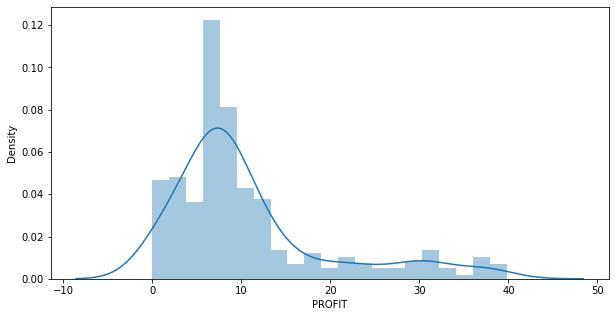

In [277]:
# Построим гистограмму и ядерную оценку плотности

fig = plt.figure(figsize=(10, 5))

sns.distplot(df3.PROFIT)

На графике видим длинный правый хвост

<AxesSubplot:>

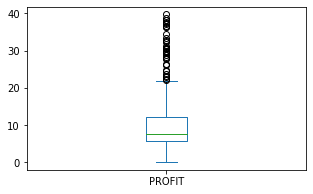

In [278]:
# Посмотрим на распределение на boxplot

df3.PROFIT.plot(kind='box')

Видим достаточно много выбросов. Попробуем разделить облигации на кластеры.

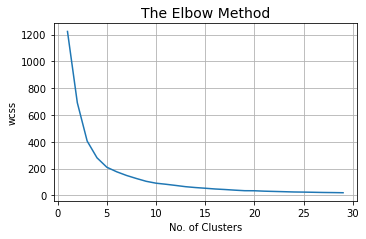

In [279]:
cols = ['PRICE','COUPONPERCENT','PROFIT','DAYS_TO_MATDATE']
#cols = bonds.columns[1:]

x = df3.loc[:,cols]
# Нормализуем данные
X = StandardScaler().fit_transform(x)

wcss = []
for i in range(1, 30):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0,
                algorithm = 'elkan',
                tol = 0.001)
    
    km.fit(X)
    labels = km.labels_
    wcss.append(km.inertia_)
    
plt.rcParams['figure.figsize'] = (5, 3)
plt.plot(range(1, 30), wcss)
plt.grid()
plt.tight_layout()
plt.title('The Elbow Method', fontsize = 14)
plt.xlabel('No. of Clusters', fontsize = 10)
plt.ylabel('wcss', fontsize = 10)
plt.show()

In [280]:
# Обучим модель с гиперпараметром n_clusters = 5

km = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0).fit(X)

df3['Cluster_Labels'] = km.labels_
df3.head()

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,DISCOUNTH0,FULLCOVERED,flag_001,DAYS_TO_MATDATE,DELTA_PRICE,NKD,YEAR_COUPONVALUE,PROFIT,Cluster,Cluster_Labels
27,RU000A0JS4Z7,ВЭБ.РФ 21,ВЭБ.РФ об. сер. 21,Корпоративные облигации,RU000A0JS4Z7,4-26-00004-T,1.0,1000.0,RUB,15000000.0,...,"10,00000",0.0,0,365,-20.700,4.817582,109.9,6.800202,0,1
55,RU000A0JTS06,Роснефть07,ПАО НК Роснефть обл.07,Корпоративные облигации,RU000A0JTS06,4-07-00122-A,1.0,1000.0,RUB,15000000.0,...,"10,00000",0.0,0,176,3.219,1.200000,35.2,3.266835,0,3
56,RU000A0JTS22,Роснефть08,ПАО НК Роснефть обл.08,Корпоративные облигации,RU000A0JTS22,4-08-00122-A,1.0,1000.0,RUB,15000000.0,...,"10,00000",0.0,0,176,2.871,1.200000,35.2,3.230714,0,3
63,RU000A0JTYJ6,ФСК ЕЭС-23,"""ФСК ЕЭС""(ПАО)-обл. сер.23",Корпоративные облигации,RU000A0JTYJ6,4-23-65018-D,3.0,1000.0,RUB,10000000.0,...,"10,00000",1.0,0,365,130.152,7.498681,161.0,30.352084,0,4
64,RU000A0JTYK4,ФСК ЕЭС-28,"""ФСК ЕЭС""(ПАО)-обл. сер.28",Корпоративные облигации,RU000A0JTYK4,4-28-65018-D,3.0,1000.0,RUB,20000000.0,...,"10,00000",1.0,0,365,130.152,7.498681,161.0,30.352084,0,4


In [281]:
# Получились кластеры
df3['Cluster_Labels'].value_counts()

1    176
3     40
2     38
0     36
4     16
Name: Cluster_Labels, dtype: int64

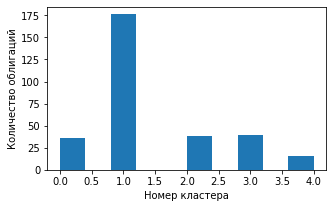

In [282]:
df3['Cluster_Labels'].plot(kind='hist')

plt.ylabel('Количество облигаций')
plt.xlabel('Номер кластера') 
plt.show()

In [283]:
# Посмотрим статистические характеристики в разрезе кластеров

claster_groups = df3.groupby('Cluster_Labels')
claster_groups.describe()['PROFIT']

,count,mean,std,min,25%,50%,75%,max
Cluster_Labels,,,,,,,,
0,36.0,4.081484,4.180802,0.000816,0.008022,2.625633,7.802378,11.919662
1,176.0,8.572907,2.686294,2.537208,6.784533,7.775246,10.430601,15.638851
2,38.0,29.387916,6.569362,17.564409,23.313154,29.699392,35.901595,39.796517
3,40.0,2.930402,1.442007,0.277429,1.856311,2.829479,3.599282,6.135566
4,16.0,23.454193,5.938708,15.328116,18.383909,20.980474,30.352084,30.784134


[]

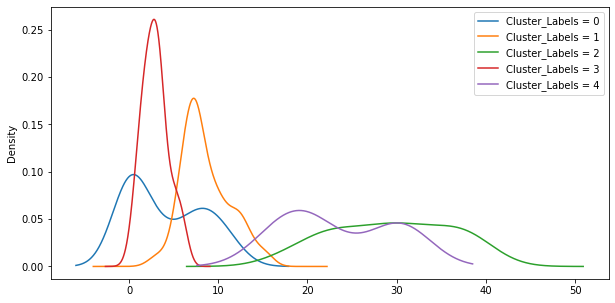

In [284]:
fig = plt.figure(figsize=(10, 5))

df3[df3.Cluster_Labels == 0]['PROFIT'].plot(kind='density', label='Cluster_Labels = 0')
df3[df3.Cluster_Labels == 1]['PROFIT'].plot(kind='density', label='Cluster_Labels = 1')
df3[df3.Cluster_Labels == 2]['PROFIT'].plot(kind='density', label='Cluster_Labels = 2')
df3[df3.Cluster_Labels == 3]['PROFIT'].plot(kind='density', label='Cluster_Labels = 3')
df3[df3.Cluster_Labels == 4]['PROFIT'].plot(kind='density', label='Cluster_Labels = 4')

plt.legend()
plt.plot()

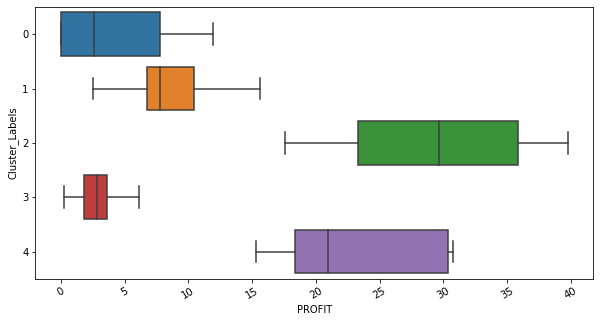

In [285]:
fig = plt.figure(figsize=(10, 5))
sns.boxplot(y='Cluster_Labels', x='PROFIT', data=df3, orient="h")

plt.xticks(rotation=30);

Из статистических характеристик и графиков видим, что у кластеров 1 и 3 плотное распределение с небольшой дисперсией. Кластера 2 и 4 имеют большую дисперсию и более плоское распределение. Доходность в них высокая, не пересекается с доходностью в других кластерах, даже в хвостах.

Посмотрим зависимость доходности от ставки купона и от цены в %%.

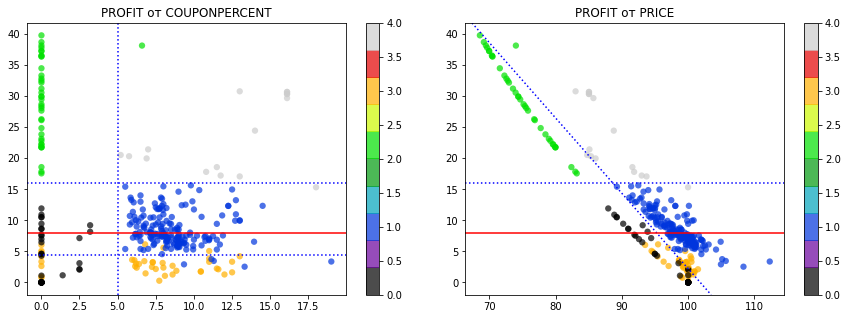

In [286]:
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.1)

plt.subplot(1, 2, 1)
plt.scatter(df3.COUPONPERCENT, df3.PROFIT, c=df3['Cluster_Labels'],
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))

#ax.vlines(4, -1, 41)
plt.axhline(y = 16, color = 'b', linestyle = ':')
plt.axhline(y = 4.5, color = 'b', linestyle = ':')
plt.axhline(y = 8, color = 'r', linestyle = '-')
plt.axvline(x = 5, color = 'b', linestyle = ':')
plt.colorbar()
plt.title('PROFIT от COUPONPERCENT')

plt.subplot(1, 2, 2)
plt.scatter(df3.PRICE, df3.PROFIT, c=df3['Cluster_Labels'],
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.axline((73, 35), (101, 1), color='b', linestyle = ':')
plt.axhline(y = 8, color = 'r', linestyle = '-')
plt.axhline(y = 16, color = 'b', linestyle = ':')

plt.colorbar()
plt.title('PROFIT от PRICE')
plt.show()

Видим четкое разделение на кластеры. 
 - Нулевой кластер (черный) имеет низкие ставки купонов, цену ниже номинала и в среднем доходность ниже ключевой ставки ЦБ (красная линия).
 - Первый кластер (синий) самый многочисленный имеет доходность вокруг ключевой ставки ЦБ от 5% до 16%
 - Второй кластер (зеленый) имеет маленькую купонную ставку, цену сильно ниже номинала и большую доходность. Доходность высокая возможно за счет большой разницы между ценой номинала и ценой покупки, а возможно за счет высокого НКД
 - Третий кластер (желтый) имеет доходность ниже ключевой ставки ЦБ
 - Четвертый кластер (серый) имеет высокую купонную ставку, цену ниже номинала и высокую доходность

Доходность облигаций во 2-ом и 4-ом кластерах сильно выше ключевой ставки ЦБ